## Vorbereitung
1. Import der Bibliotheken
2. Import der Dateien + Merge
3. Sortierung des df

In [15]:
# Imports

%pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Umsatzdaten laden
df_umsatz = pd.read_csv('data/umsatzdaten_gekuerzt.csv')
df_test = pd.read_csv('test.csv')
df_holidays = pd.read_csv('holidays_germany.csv')
df_wetter = pd.read_csv('data/wetter.csv')
df_kiwo = pd.read_csv('data/kiwo.csv')

# Datum konvertieren
df_umsatz['Datum'] = pd.to_datetime(df_umsatz['Datum'], errors='coerce')
df_test['Datum'] = pd.to_datetime(df_test['Datum'], errors='coerce')

# Zusammenführen 
df_umsatz = pd.concat([df_umsatz, df_test], ignore_index=True)

# Nach Datum sortieren
df_umsatz = df_umsatz.sort_values(by='Datum')

df_wetter['Datum'] = pd.to_datetime(df_wetter['Datum'], errors='coerce')
df_kiwo['Datum'] = pd.to_datetime(df_kiwo['Datum'], errors='coerce')

df_holidays['date'] = pd.to_datetime(df_holidays['date'], errors='coerce')
df_holidays = df_holidays.rename(columns={'date': 'Datum'})

merged_wetter_umsatz = pd.merge(df_umsatz, df_wetter, on='Datum', how='left')
merged_kiwo = pd.merge(merged_wetter_umsatz, df_kiwo, on='Datum', how='left')
df_merged = pd.merge(merged_kiwo, df_holidays, on='Datum', how='left')

df_merged = df_merged.rename(columns={'holiday': 'Feiertage'})

print("Min:", df_merged['Datum'].min())
print("Max:", df_merged['Datum'].max())

print("Min:", df_merged['Wettercode'].min())
print("Max:", df_merged['Wettercode'].max())

display(df_merged.head())
print(df_merged.shape)
print(df_merged['Datum'].is_monotonic_increasing)


Min: 2013-07-01 00:00:00
Max: 2019-07-30 00:00:00
Min: 0.0
Max: 95.0


,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Feiertage
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,NaN,NaN
1,1307013,2013-07-01,3,201.198426,6.0,17.8375,15.0,20.0,NaN,NaN
2,1307014,2013-07-01,4,65.890169,6.0,17.8375,15.0,20.0,NaN,NaN
3,1307015,2013-07-01,5,317.475875,6.0,17.8375,15.0,20.0,NaN,NaN
4,1307012,2013-07-01,2,535.856285,6.0,17.8375,15.0,20.0,NaN,NaN


(11164, 10)
True


## Data Cleaning

In [17]:
# Data Cleaning vorher

# Wetter- und Feature-Daten bereinigen
#df_merged['Temperatur'] = df_merged['Temperatur'].fillna(df_merged['Temperatur'].mean)
# df_merged['Temperatur'] = df_merged['Temperatur'].fillna(df_merged['Temperatur'].mean())
# df_merged['KielerWoche'] = df_merged['KielerWoche'].fillna(0)
# df_merged['Wettercode'] = df_merged['Wettercode'].fillna(0)
# df_merged['Bewoelkung'] = df_merged['Bewoelkung'].fillna(df_merged['Bewoelkung'].mean())
#df_merged['Windgeschwindigkeit'] = df_merged['Windgeschwindigkeit'].fillna(df_merged['Windgeschwindigkeit'].mean())
#df_merged['Feiertage'] = df_merged['Feiertage'].fillna('Kein Feiertag')

In [18]:
df_merged['Datum'] = pd.to_datetime(df_merged['Datum'], errors='coerce')
df_merged['Monat'] = df_merged['Datum'].dt.month
df_merged['Wochentag'] = df_merged['Datum'].dt.weekday
df_merged = df_merged.drop_duplicates()

df_with_umsatz = df_merged[df_merged['Umsatz'].notna()].copy()
df_without_umsatz = df_merged[df_merged['Umsatz'].isna()].copy()

print(f"Zeilen mit Umsatz: {len(df_with_umsatz)}")
print(f"Zeilen ohne Umsatz (zum Vorhersagen): {len(df_without_umsatz)}")

print("Min:", df_merged['Datum'].min())
print("Max:", df_merged['Datum'].max())

print(df_merged.isna().sum())
df_merged.head()

Zeilen mit Umsatz: 9334
Zeilen ohne Umsatz (zum Vorhersagen): 1830
Min: 2013-07-01 00:00:00
Max: 2019-07-30 00:00:00
id                         0
Datum                      0
Warengruppe                0
Umsatz                  1830
Bewoelkung               135
Temperatur                81
Windgeschwindigkeit       81
Wettercode              2662
KielerWoche            10896
Feiertage              11059
Monat                      0
Wochentag                  0
dtype: int64


,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Feiertage,Monat,Wochentag
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,NaN,NaN,7,0
1,1307013,2013-07-01,3,201.198426,6.0,17.8375,15.0,20.0,NaN,NaN,7,0
2,1307014,2013-07-01,4,65.890169,6.0,17.8375,15.0,20.0,NaN,NaN,7,0
3,1307015,2013-07-01,5,317.475875,6.0,17.8375,15.0,20.0,NaN,NaN,7,0
4,1307012,2013-07-01,2,535.856285,6.0,17.8375,15.0,20.0,NaN,NaN,7,0


### Analyse der fehlenden Temperatur-Werte

In [19]:
df_merged['Temperatur'].isna().sum(), df_merged['Temperatur'].dtype
df_merged[['Datum','Temperatur']].head(5)
df_merged[['Datum','Temperatur']].tail(5)

missing = df_merged[df_merged['Temperatur'].isna()].copy()
missing[['Datum','Temperatur']].head(20)  # erhalte ein Gefühl

# Zeige für die fehlenden Zeilen die Vor- und Nachwerte:
display(pd.concat([
    missing[['Datum','Temperatur']],
    df_merged['Temperatur'].shift(1).loc[missing.index].rename('temp_minus1'),
    df_merged['Temperatur'].shift(-1).loc[missing.index].rename('temp_plus1')
], axis=1).head(30))

isna = df_merged['Temperatur'].isna().astype(int)
# Laufende Gruppenlängen der NaNs:
g = (isna != isna.shift()).cumsum()
na_groups = isna.groupby(g).sum()
# Filter nur die Gruppen >0 (also nur die Na-Gruppen); zeige Verteilung:
na_group_lengths = na_groups[na_groups>0].value_counts().sort_index()
# In eine DataFrame umwandeln und Spaltenüberschriften setzen 
df_na_group_lengths = na_group_lengths.reset_index()
df_na_group_lengths.columns = ['Länge der NaN-Gruppe Temperatur', 'Häufigkeiten']  
display(df_na_group_lengths)

,Datum,Temperatur,temp_minus1,temp_plus1
6348,2016-12-11,NaN,9.5000,NaN
6349,2016-12-11,NaN,NaN,NaN
6350,2016-12-11,NaN,NaN,NaN
6351,2016-12-11,NaN,NaN,NaN
6352,2016-12-11,NaN,NaN,NaN
6353,2016-12-11,NaN,NaN,4.8750
7813,2017-10-04,NaN,14.2625,NaN
7814,2017-10-04,NaN,NaN,NaN
7815,2017-10-04,NaN,NaN,NaN
7816,2017-10-04,NaN,NaN,NaN


,Länge der NaN-Gruppe Temperatur,Häufigkeiten
0,5,1
1,6,1
2,10,4
3,30,1


--> es ergibt keinen Sinn die Mittelwerte der angrenzenden Tage zu nehmen, da die Werte immer als Reihe fehlen

### Analyse Windgeschwindigkeit

In [20]:
df_merged['Windgeschwindigkeit'].isna().sum(), df_merged['Windgeschwindigkeit'].dtype
df_merged[['Datum','Windgeschwindigkeit']].head(5)
df_merged[['Datum','Windgeschwindigkeit']].tail(5)

missing = df_merged[df_merged['Windgeschwindigkeit'].isna()].copy()
missing[['Datum','Windgeschwindigkeit']].head(20)  # erhalte ein Gefühl

# Zeige für die fehlenden Zeilen die Vor- und Nachwerte:
display(pd.concat([
    missing[['Datum','Windgeschwindigkeit']],
    df_merged['Windgeschwindigkeit'].shift(1).loc[missing.index].rename('temp_minus1'),
    df_merged['Windgeschwindigkeit'].shift(-1).loc[missing.index].rename('temp_plus1')
], axis=1).head(30))

isna = df_merged['Windgeschwindigkeit'].isna().astype(int)
# Laufende Gruppenlängen der NaNs:
g = (isna != isna.shift()).cumsum()
na_groups = isna.groupby(g).sum()
# Filter nur die Gruppen >0 (also nur die Na-Gruppen); zeige Verteilung:
na_group_lengths = na_groups[na_groups>0].value_counts().sort_index()
# In eine DataFrame umwandeln und Spaltenüberschriften setzen 
df_na_group_lengths = na_group_lengths.reset_index()
df_na_group_lengths.columns = ['Länge der NaN-Gruppe Windgeschwindigkeit', 'Häufigkeiten']  
display(df_na_group_lengths)

,Datum,Windgeschwindigkeit,temp_minus1,temp_plus1
6348,2016-12-11,NaN,10.0,NaN
6349,2016-12-11,NaN,NaN,NaN
6350,2016-12-11,NaN,NaN,NaN
6351,2016-12-11,NaN,NaN,NaN
6352,2016-12-11,NaN,NaN,NaN
6353,2016-12-11,NaN,NaN,4.0
7813,2017-10-04,NaN,14.0,NaN
7814,2017-10-04,NaN,NaN,NaN
7815,2017-10-04,NaN,NaN,NaN
7816,2017-10-04,NaN,NaN,NaN


,Länge der NaN-Gruppe Windgeschwindigkeit,Häufigkeiten
0,5,1
1,6,1
2,10,4
3,30,1


In [21]:
# Vergleich: Fehlende Werte in Temperatur und Windgeschwindigkeit
# 1. Überlappung prüfen: Welche Zeilen haben BEIDE Spalten als NaN?
both_missing = df_merged[(df_merged['Temperatur'].isna()) & (df_merged['Windgeschwindigkeit'].isna())]
print(f"Zeilen, wo BEIDE (Temperatur & Windgeschwindigkeit) fehlen: {len(both_missing)}")

# 2. Nur Temperatur fehlt (aber Windgeschwindigkeit vorhanden)
only_temp_missing = df_merged[(df_merged['Temperatur'].isna()) & (df_merged['Windgeschwindigkeit'].notna())]
print(f"Zeilen, wo NUR Temperatur fehlt: {len(only_temp_missing)}")

# 3. Nur Windgeschwindigkeit fehlt (aber Temperatur vorhanden)
only_wind_missing = df_merged[(df_merged['Windgeschwindigkeit'].isna()) & (df_merged['Temperatur'].notna())]
print(f"Zeilen, wo NUR Windgeschwindigkeit fehlt: {len(only_wind_missing)}")

# 4. Zusammenfassung als Tabelle
summary = pd.DataFrame({
    'Kategorie': ['Beide fehlen', 'Nur Temperatur fehlt', 'Nur Windgeschwindigkeit fehlt'],
    'Anzahl': [len(both_missing), len(only_temp_missing), len(only_wind_missing)]
})
display(summary)

# 5. Beispiel: Zeige ein paar Zeilen, wo beide fehlen
print("\nBeispiele (erste 10 Zeilen, wo beide fehlen):")
display(both_missing[['Datum', 'Temperatur', 'Windgeschwindigkeit']].head(10))

Zeilen, wo BEIDE (Temperatur & Windgeschwindigkeit) fehlen: 81
Zeilen, wo NUR Temperatur fehlt: 0
Zeilen, wo NUR Windgeschwindigkeit fehlt: 0


,Kategorie,Anzahl
0,Beide fehlen,81
1,Nur Temperatur fehlt,0
2,Nur Windgeschwindigkeit fehlt,0



Beispiele (erste 10 Zeilen, wo beide fehlen):


,Datum,Temperatur,Windgeschwindigkeit
6348,2016-12-11,NaN,NaN
6349,2016-12-11,NaN,NaN
6350,2016-12-11,NaN,NaN
6351,2016-12-11,NaN,NaN
6352,2016-12-11,NaN,NaN
6353,2016-12-11,NaN,NaN
7813,2017-10-04,NaN,NaN
7814,2017-10-04,NaN,NaN
7815,2017-10-04,NaN,NaN
7816,2017-10-04,NaN,NaN


Löschen der 81 Zeilen mit fehlenden Temperatur- und Windgeschwindigkeitsdaten; 81 Zeilen = 15 Tage

### Option 1: Löschen

In [22]:
# Zeilen mit fehlenden Werten löschen - verschiedene Optionen

print(f"Originale Anzahl Zeilen: {len(df_merged)}")
print(f"Originale fehlende Werte:\n{df_merged.isna().sum()}\n")

# Option 2: Nur Zeilen mit NaN in SPEZIFISCHEN Spalten löschen
df_merged = df_merged.dropna(subset=['Temperatur', 'Windgeschwindigkeit'])
print(f"Nach dropna: {len(df_merged)} Zeilen")

Originale Anzahl Zeilen: 11164
Originale fehlende Werte:
id                         0
Datum                      0
Warengruppe                0
Umsatz                  1830
Bewoelkung               135
Temperatur                81
Windgeschwindigkeit       81
Wettercode              2662
KielerWoche            10896
Feiertage              11059
Monat                      0
Wochentag                  0
dtype: int64

Nach dropna: 11083 Zeilen


In [23]:
# Feature-Daten bereinigen
df_merged['KielerWoche'] = df_merged['KielerWoche'].fillna(0)
df_merged['Feiertage'] = df_merged['Feiertage'].fillna(0)

df_with_umsatz = df_merged[df_merged['Umsatz'].notna()].copy()
df_without_umsatz = df_merged[df_merged['Umsatz'].isna()].copy()

print(f"Zeilen mit Umsatz: {len(df_with_umsatz)}")
print(f"Zeilen ohne Umsatz (zum Vorhersagen): {len(df_without_umsatz)}")

df_merged.to_csv("data/df_merged_new.csv", index=False)

print("Min:", df_merged['Datum'].min())
print("Max:", df_merged['Datum'].max())


print(df_merged.isna().sum())
df_merged.head()

Zeilen mit Umsatz: 9318
Zeilen ohne Umsatz (zum Vorhersagen): 1765


Min: 2013-07-01 00:00:00
Max: 2019-07-30 00:00:00
id                        0
Datum                     0
Warengruppe               0
Umsatz                 1765
Bewoelkung               54
Temperatur                0
Windgeschwindigkeit       0
Wettercode             2581
KielerWoche               0
Feiertage                 0
Monat                     0
Wochentag                 0
dtype: int64


,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Feiertage,Monat,Wochentag
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,0.0,0,7,0
1,1307013,2013-07-01,3,201.198426,6.0,17.8375,15.0,20.0,0.0,0,7,0
2,1307014,2013-07-01,4,65.890169,6.0,17.8375,15.0,20.0,0.0,0,7,0
3,1307015,2013-07-01,5,317.475875,6.0,17.8375,15.0,20.0,0.0,0,7,0
4,1307012,2013-07-01,2,535.856285,6.0,17.8375,15.0,20.0,0.0,0,7,0


## One-Hot-Encoding: Categorical Data

1. Wettercode
2. Warengruppe + Wochentag + Monat + Bewoelkung + Feiertage 

In [24]:
## hier dokument einfügen: wettercde_onehot_encoded.ipynb

In [25]:
print(df_merged['Wettercode'].value_counts())

Wettercode
61.0    2777
21.0    1193
0.0     1044
10.0     865
5.0      774
63.0     580
20.0     307
95.0     172
22.0     115
65.0     111
45.0     106
71.0      91
28.0      74
49.0      53
53.0      48
73.0      48
77.0      45
69.0      27
75.0      25
68.0      22
17.0      10
79.0       5
3.0        5
55.0       5
Name: count, dtype: int64


In [26]:
# Debug-Ausgabe
print("dtype vor Änderung:", df_merged['Wettercode'].dtype)

# Falls noch kein category dtype: konvertieren
if not pd.api.types.is_categorical_dtype(df_merged['Wettercode']):
    df_merged['Wettercode'] = df_merged['Wettercode'].astype('category')

# Jetzt sicher Kategorien hinzufügen und NaNs ersetzen
df_merged['Wettercode'] = df_merged['Wettercode'].cat.add_categories(['Keine Daten'])
df_merged['Wettercode'] = df_merged['Wettercode'].fillna('Keine Daten')

print("dtype nach Änderung:", df_merged['Wettercode'].dtype)
print(df_merged['Wettercode'].value_counts())

dtype vor Änderung: float64
dtype nach Änderung: category
Wettercode
61.0           2777
Keine Daten    2581
21.0           1193
0.0            1044
10.0            865
5.0             774
63.0            580
20.0            307
95.0            172
22.0            115
65.0            111
45.0            106
71.0             91
28.0             74
49.0             53
53.0             48
73.0             48
77.0             45
69.0             27
75.0             25
68.0             22
17.0             10
3.0               5
55.0              5
79.0              5
Name: count, dtype: int64


/tmp/ipykernel_53093/3099108898.py:5: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_merged['Wettercode']):


In [27]:
print("Spalten in df_merged:", list(df_merged.columns))
if 'Wettercode' not in df_merged.columns:
    print("FEHLER: Spalte 'Wettercode' fehlt. Zeige ersten 5 Zeilen:")
    display(df_merged.head())

Spalten in df_merged: ['id', 'Datum', 'Warengruppe', 'Umsatz', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode', 'KielerWoche', 'Feiertage', 'Monat', 'Wochentag']


In [28]:
# Wettercodes in Kategorien gruppieren mit Mapping

wettercode_mapping = {
    0.0: 'Klar',
    5.0: 'Trockener_Dunst',
    10.0: 'Feuchter_Dunst',
    20.0: 'Sprühregen_oder_Schneegriesel_aufgehoert',
    21.0: 'Regen_aufgehört',
    22.0: 'Schnee_aufgehört',
    28.0: 'Nebel_aufgehört',
    45.0: 'Nebel',
    49.0: 'Nebel+Reifansatz',
    53.0: 'andauernder_Sprühregen',
    61.0: 'Durchgehender_Leichter_Regen',
    63.0: 'Durchgehender_Mässiger_Regen',
    65.0: 'Durchgehender_Starker_Regen',
    69.0: 'Mäßiger_bis_starker_Schneeregen',
    71.0: 'Durchgehender_leichter_Schneefall',          
    73.0: 'Durchgehender_mäßiger_Schneefall',          
    75.0: 'Durchgehender_starker_Schneefall',
    77.0: 'Schneegriesel',
    79.0: 'Eiskörner',
    95.0: 'Gewitter',
    'Keine_Daten': 'Keine_Daten'
}


df_merged['Wettercode'] = df_merged['Wettercode'].map(wettercode_mapping)

#alle_kategorien = ['Klar','Dunst','Nebel','Sprühregen_oder_Schneegriesel_aufgehoert',
#                    'Regen_aufgehoert','Schnee_aufgehoert','Nebel_aufgehoert','Nebel+Reifansatz',
#                    'andauernder_Sprühregen','Mässiger_Regen','Schneeregen','Schneefall',
#                    'Schneegriesel','Eiskörner','Gewitter','Keine_Daten']  

df_merged['Wettercode'] = pd.Categorical(df_merged['Wettercode'], categories=wettercode_mapping.values())

# One-Hot-Encoding auf die neuen Kategorien
df_merged = pd.get_dummies(df_merged, columns=['Wettercode'], dtype=int, prefix='Wetter', prefix_sep='_')

print("Wetterkategorien-Verteilung:")
#print(df_merged['Wettercode'].value_counts())


df_merged.to_csv('data/df_wettercode_encoded_2.csv', index=False)

print(df_merged.head())



Wetterkategorien-Verteilung:


        id      Datum  Warengruppe      Umsatz  Bewoelkung  Temperatur  \
0  1307011 2013-07-01            1  148.828353         6.0     17.8375   
1  1307013 2013-07-01            3  201.198426         6.0     17.8375   
2  1307014 2013-07-01            4   65.890169         6.0     17.8375   
3  1307015 2013-07-01            5  317.475875         6.0     17.8375   
4  1307012 2013-07-01            2  535.856285         6.0     17.8375   

   Windgeschwindigkeit  KielerWoche Feiertage  Monat  ...  \
0                 15.0          0.0         0      7  ...   
1                 15.0          0.0         0      7  ...   
2                 15.0          0.0         0      7  ...   
3                 15.0          0.0         0      7  ...   
4                 15.0          0.0         0      7  ...   

   Wetter_Durchgehender_Mässiger_Regen  Wetter_Durchgehender_Starker_Regen  \
0                                    0                                   0   
1                               

## Data Splitting 

In [29]:
# Dataset Splitting

train = df_merged[(df_merged['Datum'] >= '2013-07-01') & (df_merged['Datum'] <= '2017-07-31')]
validation = df_merged[(df_merged['Datum'] >= '2017-08-01') & (df_merged['Datum'] <= '2018-07-31')]
test  = df_merged[(df_merged['Datum'] >= '2018-08-01') & (df_merged['Datum'] <= '2019-07-31')]

print("Train shape :", train.shape)
print("Validation shape :", validation.shape)
print("Test shape :", test.shape)

train.to_csv("data/train_data.csv", index=False)
validation.to_csv("data/validation_data.csv", index=False)
test.to_csv("data/test_data.csv", index=False)


Train shape : (7487, 32)
Validation shape : (1831, 32)
Test shape : (1765, 32)


## Plots

In [30]:
# Pairplots

columns = ['Datum', 'Warengruppe', 'Umsatz', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode', 'KielerWoche', 'Feiertage', 'Monat', 'Wochentag']

sns.pairplot(df_merged[columns])

df_merged[columns].corr()



KeyError: "['Wettercode'] not in index"

,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Monat,Wochentag
count,9.334000e+03,9334,9334.000000,9334.000000,9334.000000,9334.000000,9334.000000,9334.000000,9334.000000,9334.000000,9334.000000
mean,1.559311e+06,2016-01-13 23:56:27.100921344,3.088172,206.749044,4.720876,12.028472,10.974842,27.708699,0.023891,6.654810,3.000536
min,1.307011e+06,2013-07-01 00:00:00,1.000000,7.051201,0.000000,-8.475000,3.000000,0.000000,0.000000,1.000000,0.000000
25%,1.410123e+06,2014-10-12 00:00:00,2.000000,96.897441,3.000000,6.250000,8.000000,0.000000,0.000000,4.000000,1.000000
50%,1.601102e+06,2016-01-10 00:00:00,3.000000,161.900831,6.000000,11.656250,10.000000,20.000000,0.000000,7.000000,3.000000
75%,1.704223e+06,2017-04-22 00:00:00,4.000000,280.644663,7.000000,17.962500,13.000000,61.000000,0.000000,10.000000,5.000000
max,1.807315e+06,2018-07-31 00:00:00,6.000000,1879.461831,8.000000,31.437500,35.000000,95.000000,1.000000,12.000000,6.000000
std,1.512503e+05,NaN,1.489002,144.545189,2.636331,7.226626,4.128431,28.390122,0.152718,3.461902,2.001044


Warengruppe
1    1819
3    1819
5    1819
2    1819
4    1766
6     292
Name: count, dtype: int64
Feiertage
Kein Feiertag                9234
Tag der Deutschen Einheit      25
Ostermontag                    25
Christi Himmelfahrt            25
Pfingstmontag                  20
Erster Mai                      5
Name: count, dtype: int64


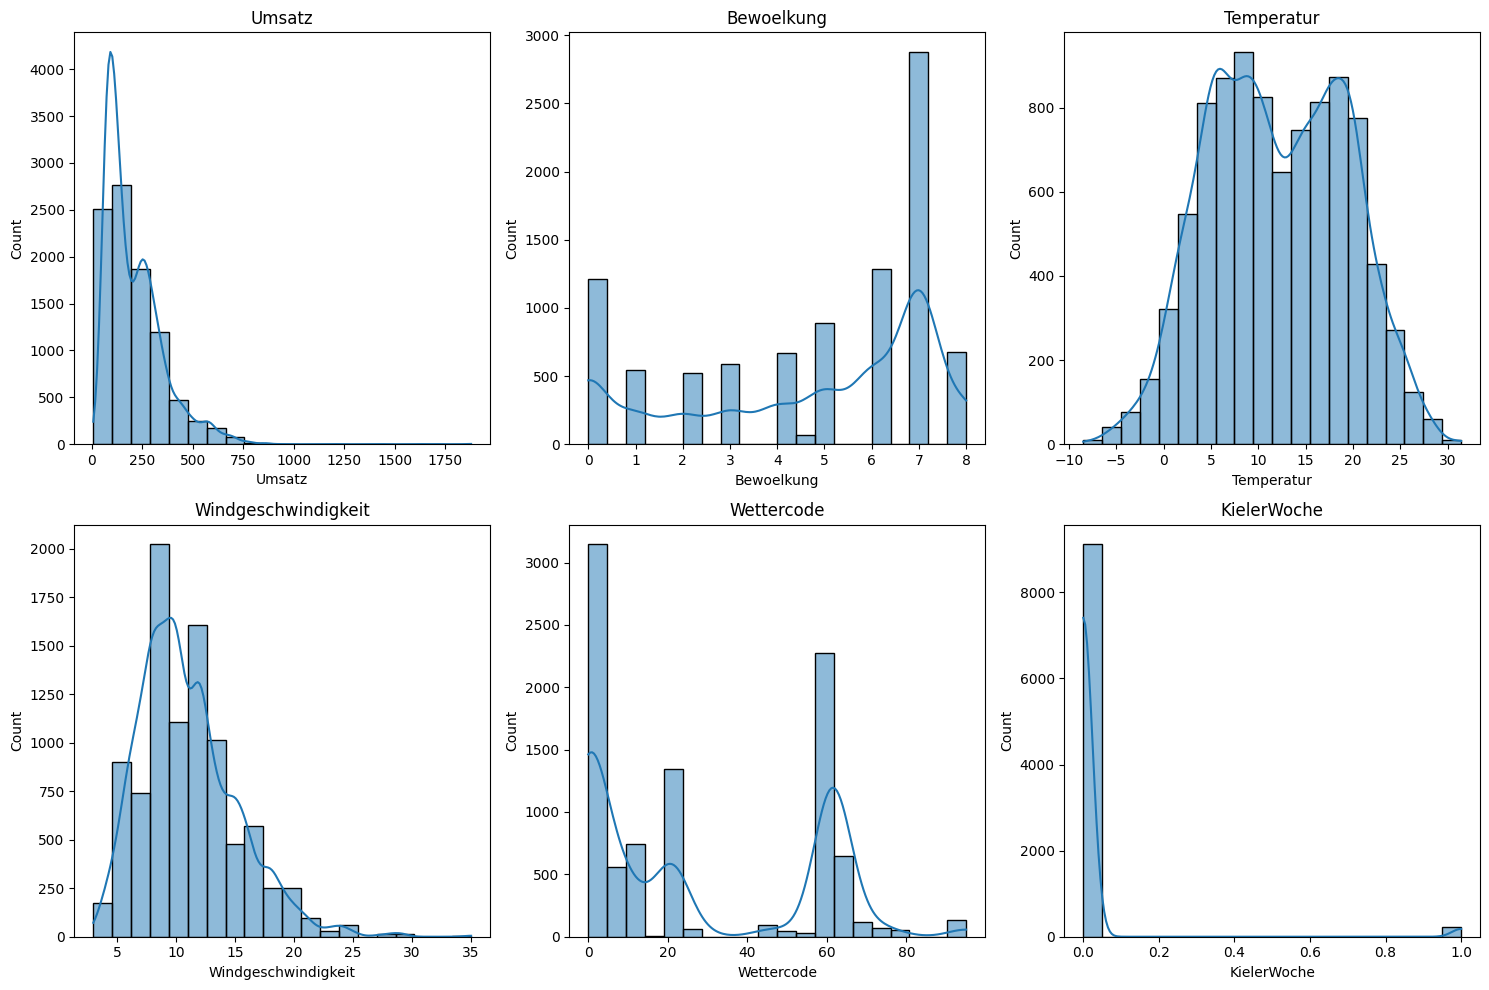

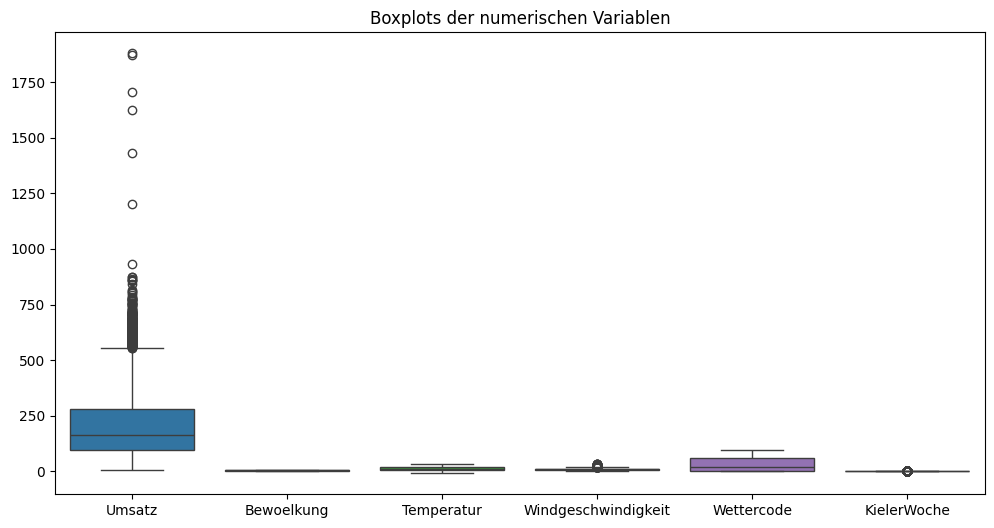

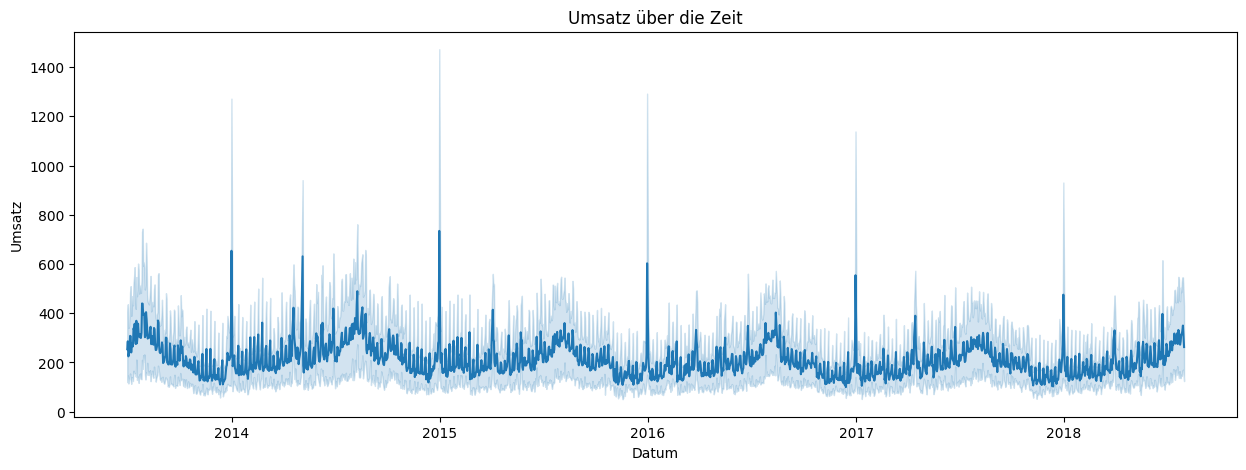

/tmp/ipykernel_20153/2591877749.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_merged, x='Warengruppe', y='Umsatz', ci=None)


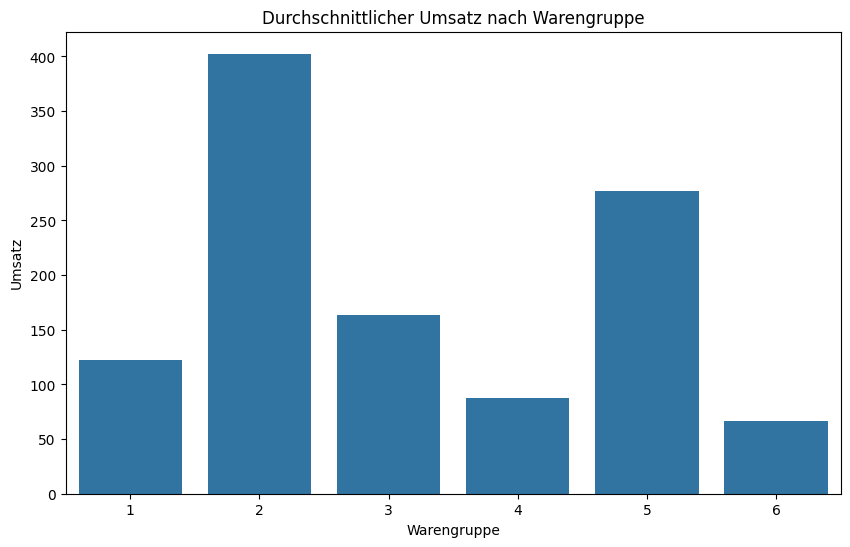

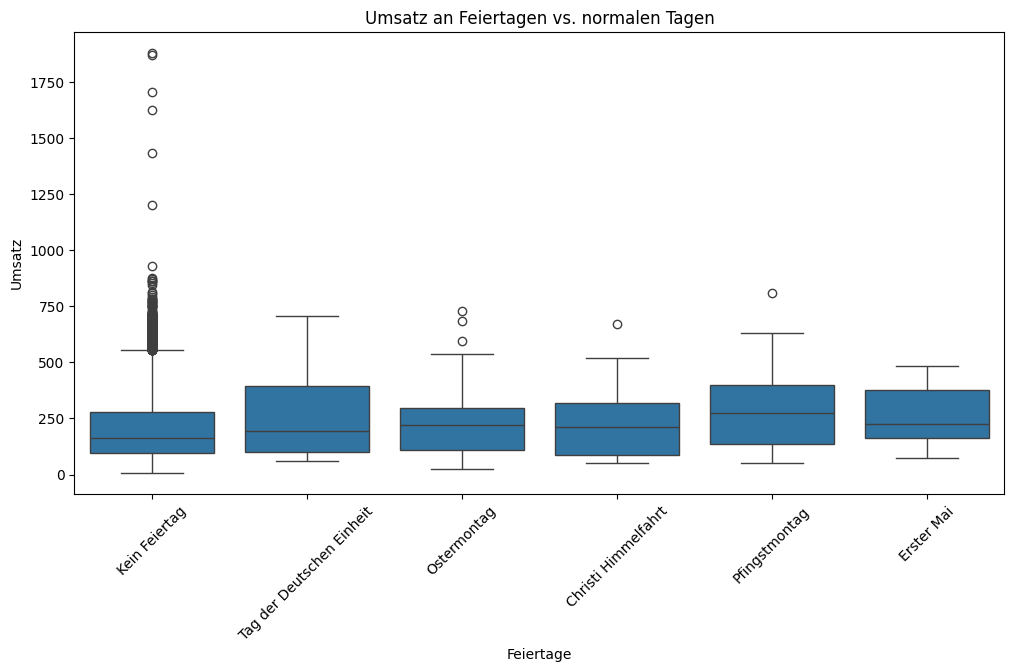

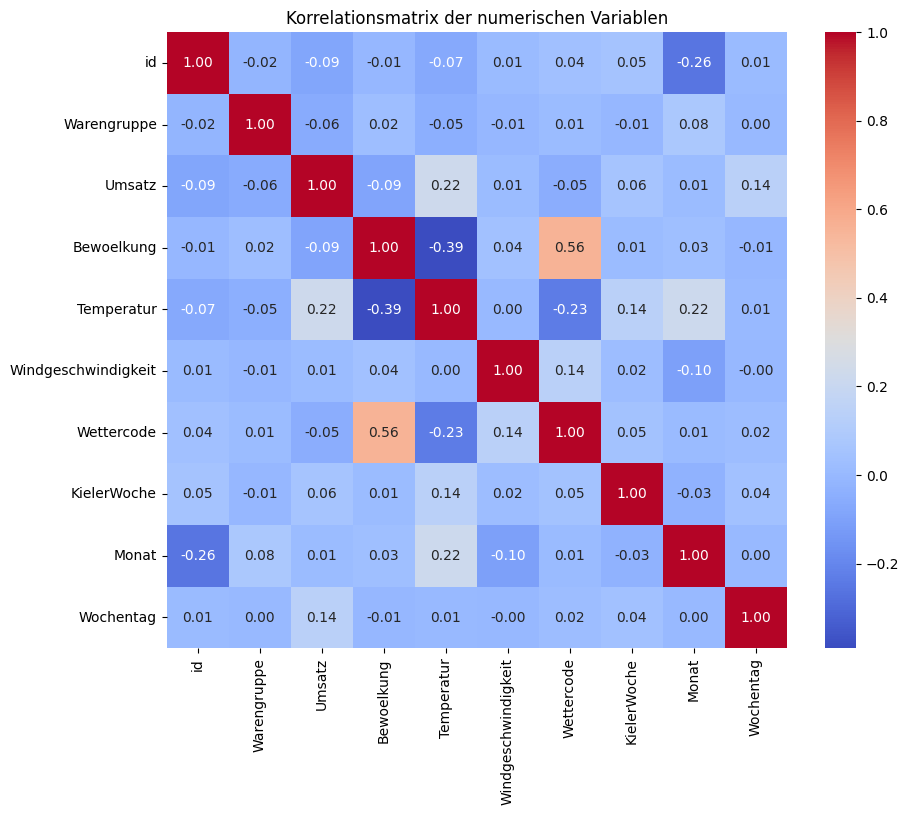

/tmp/ipykernel_20153/2591877749.py:62: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_merged, x='Wochentag', y='Umsatz', ci=None)


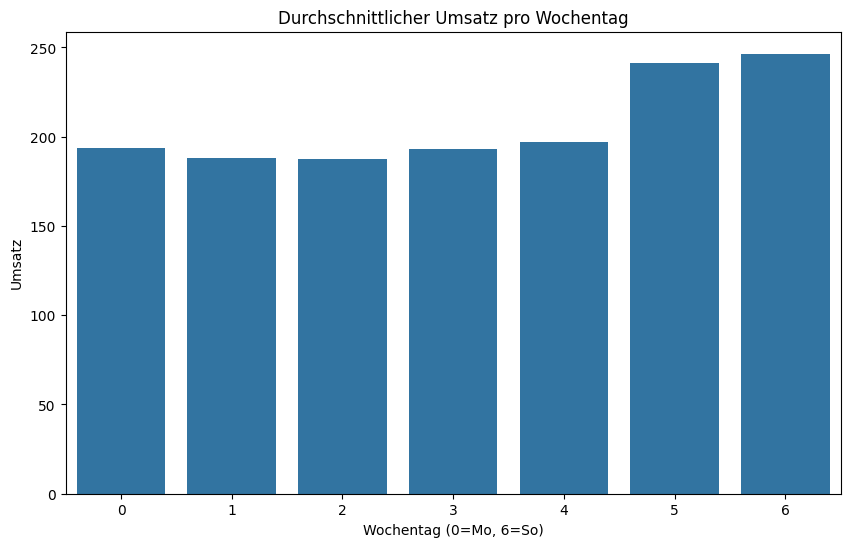

In [ ]:
# Descriptive statistics and visualizations for the respective variables

display(df_merged.describe())
df_merged.isna().sum()


print(df_merged['Warengruppe'].value_counts())
print(df_merged['Feiertage'].value_counts())

# Histogramme für numerische Variablen
numerische_spalten = ['Umsatz', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode', 'KielerWoche']

plt.figure(figsize=(15,10))
for i, col in enumerate(numerische_spalten, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_merged[col], kde=True, bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()
kde=True 

# Boxplots für numerische Variablen (Ausreißer erkennen)
plt.figure(figsize=(12,6))
sns.boxplot(data=df_merged[numerische_spalten])
plt.title("Boxplots der numerischen Variablen")
plt.show()

# Umsatz über die Zeit
plt.figure(figsize=(15,5))
sns.lineplot(data=df_merged, x='Datum', y='Umsatz')
plt.title("Umsatz über die Zeit")
plt.xlabel("Datum")
plt.ylabel("Umsatz")
plt.show()

# Umsatz nach Warengruppe
plt.figure(figsize=(10,6))
sns.barplot(data=df_merged, x='Warengruppe', y='Umsatz', ci=None)
plt.title("Durchschnittlicher Umsatz nach Warengruppe")
plt.show()

# Umsatz an Feiertagen vs. normalen Tagen
plt.figure(figsize=(12,6))
sns.boxplot(data=df_merged, x='Feiertage', y='Umsatz')
plt.xticks(rotation=45)
plt.title("Umsatz an Feiertagen vs. normalen Tagen")
plt.show()

# Korrelationsmatrix
numerische_df = df_merged.select_dtypes(include='number')

# Korrelationsmatrix plotten
plt.figure(figsize=(10,8))
sns.heatmap(numerische_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korrelationsmatrix der numerischen Variablen")
plt.show()

# Wochentag-Analyse
df_merged['Wochentag'] = df_merged['Datum'].dt.weekday  # 0 = Montag

plt.figure(figsize=(10,6))
sns.barplot(data=df_merged, x='Wochentag', y='Umsatz', ci=None)
plt.title("Durchschnittlicher Umsatz pro Wochentag")
plt.xlabel("Wochentag (0=Mo, 6=So)")
plt.show()



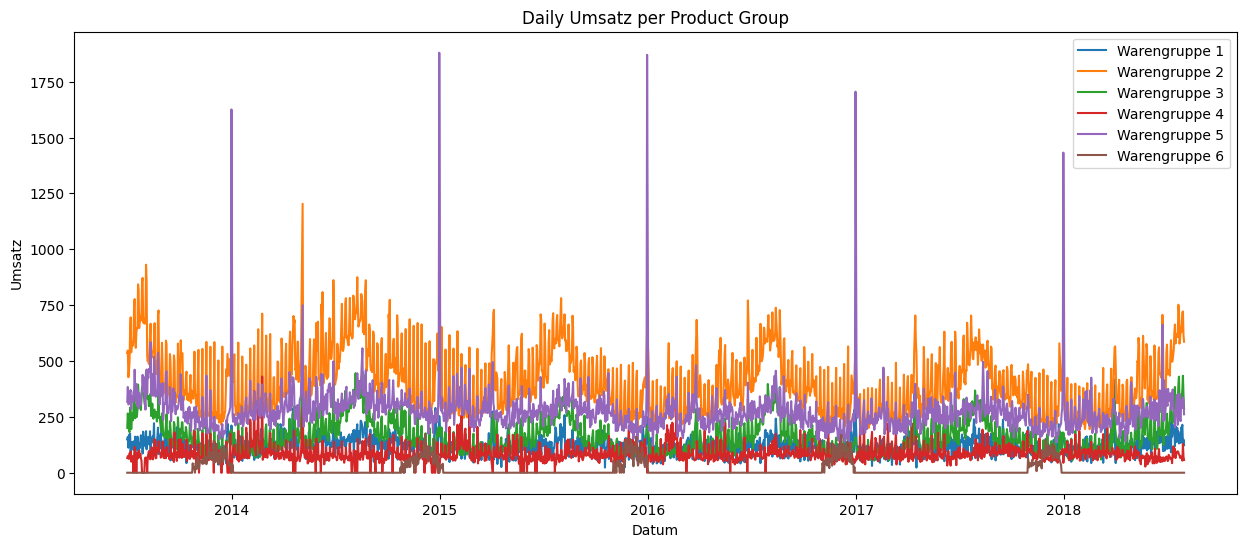

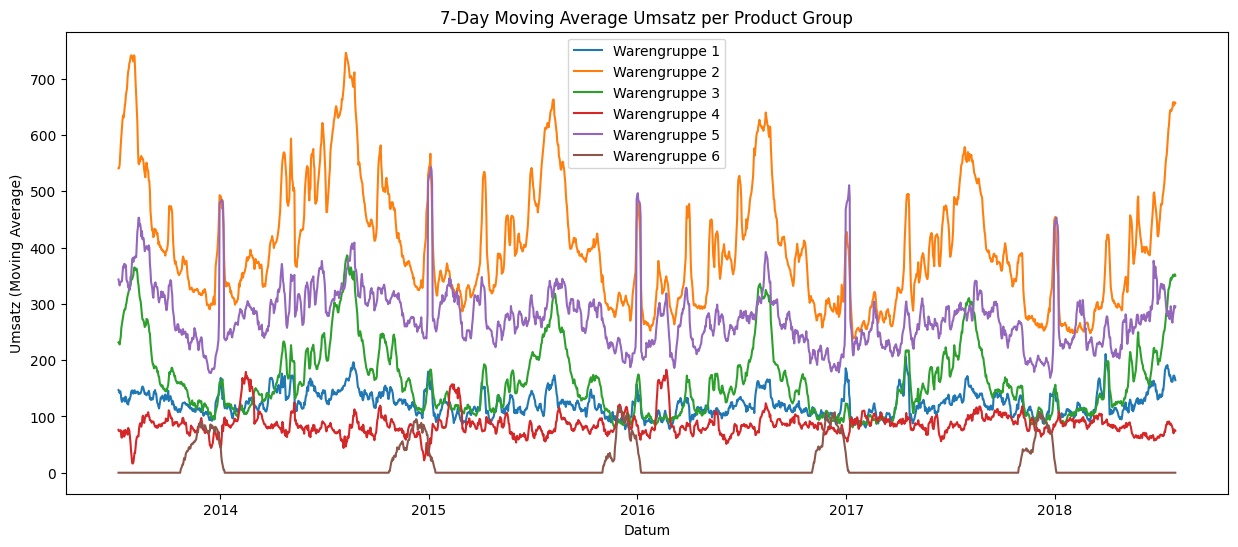

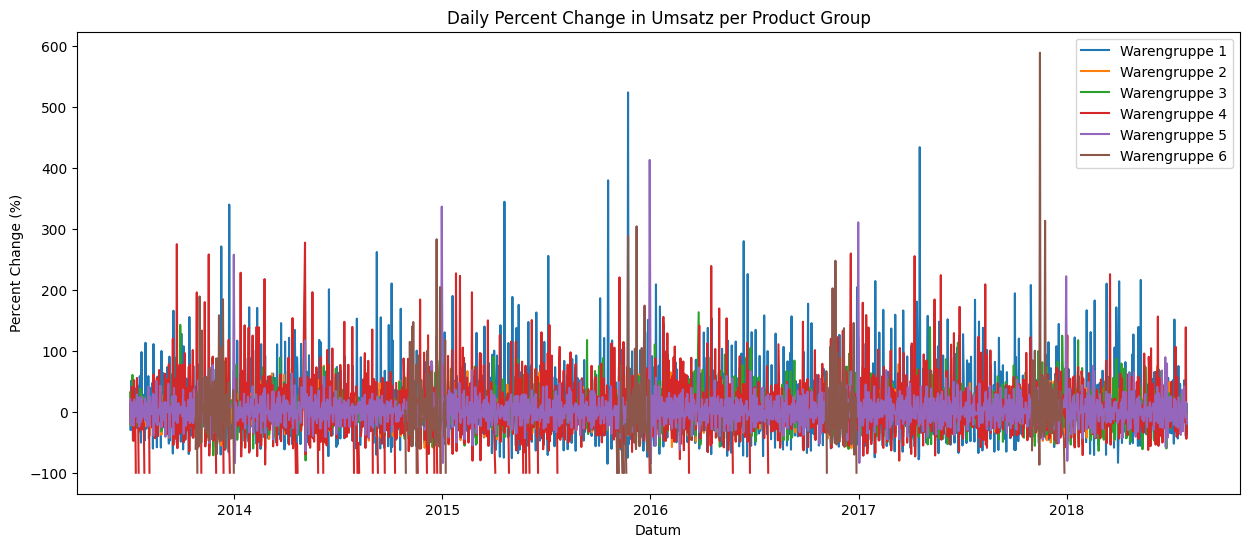

In [ ]:
# Time Series

df_merged = df_merged.sort_values('Datum')
df_grouped = df_merged.groupby(['Datum', 'Warengruppe'])['Umsatz'].sum().reset_index()

df_pivot = df_grouped.pivot(index='Datum', columns='Warengruppe', values='Umsatz')
df_pivot = df_pivot.fillna(0)  
df_pivot.head()

# Moving Averages
moving_avg = df_pivot.rolling(window=7).mean()

# Percent Change
pct_change = df_pivot.pct_change() * 100  # convert to percentage

plt.figure(figsize=(15,6))
for col in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[col], label=f'Warengruppe {col}')

plt.title('Daily Umsatz per Product Group')
plt.xlabel('Datum')
plt.ylabel('Umsatz')
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
for col in moving_avg.columns:
    plt.plot(moving_avg.index, moving_avg[col], label=f'Warengruppe {col}')

plt.title('7-Day Moving Average Umsatz per Product Group')
plt.xlabel('Datum')
plt.ylabel('Umsatz (Moving Average)')
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
for col in pct_change.columns:
    plt.plot(pct_change.index, pct_change[col], label=f'Warengruppe {col}')
plt.title('Daily Percent Change in Umsatz per Product Group')
plt.xlabel('Datum')
plt.ylabel('Percent Change (%)')
plt.legend()
plt.show()